# Capstone Project  - Car accidents in Seattle

## Applied Data Science IBM Course

## Table of contents
* [Introduction](#intro)
* [Data](#data)
* [Methods](#methods)
* [Analysis](#analysis)
* [Modeling](#modeling)
* [Evaluation](#evaluation)

## Introduction <a name="intro"></a>

According to the Washington State Department of Transportation (WSDOT), car accidents happen in **Seattle** with a high frequency. It is estimated that an incident occurs every **4 minutes** and fatal accidents that leave victims dead occur every 20 hours. In this sense, fatal accidents went from 508 in 2016 to 525 in 2017, leaving a total of **555 fatalities**. Typical conditions that contribute to such fatal events include alcohol use, motorcycle use, and pedestrians. Here we evaluate the different types of incidents that occurred in Seattle and consider the different conditions that led to them. For this, the data record of incidents, locations and important conditions since 2004 is used. Based on the data provided, correlations between different areas and parameters, such as alcohol use, vehicle type, weather and street conditions, etc., are of use to detect the most common type of accident and its causes.

### Audience

- Traffic departments, such as the WSDOT, that are looking to reduce the number of incidents.
- General public, including pedestrians, cyclist, drivers who can decide their routes based on the likelihood of an incident. 
- Car insurance companies looking to estimate costs from the number and type of incidents.

## Data <a name='data'></a>

The data provided by <a href='https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Metadata.pdf'>SPD</a> and Traffic Records consist of **194,673** incidents reported in Seattle from 2004 to the present. There are primary and secondary keys associated with every accident, including the specific location, date and time. All kinds of collisions have been recorded, including cars, pedestrians and cyclists. In total, more than 15 different conditions have been recorded, e.g. weather, types of location (alley, mid-block, intersections), alcohol or drug abuse, etc. In addition, the severity of the accident is denoted by the severity code. We started looking in the **areas** with the most fatal incidents reported. Then, a classification using common conditions is used to assess the severity of the accident. Based on our findings, we report specific conditions and areas in Seattle that should be a priority for future prevention of car accidents.

In [1829]:
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sb
import wget
import folium
import vincent
import json
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from IPython.display import HTML
import random

import matplotlib.pyplot as plt
markers = ['o','s','^','p']
c = 'k'
ms = 12
plt.rcParams['axes.labelsize']=20
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['font.size']=20

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Show/Hide Cell'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

In [80]:
# data = wget.download('https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv')
collisions = pd.read_csv('Data-Collisions.csv')

/Users/Abraham/.pyenv/versions/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [1919]:
directory = '/Users/Abraham/Documents/IBM_certificate/'

In [1832]:
import datetime as dt
collisions['INCDTTM'] = pd.to_datetime(collisions['INCDTTM'])
collisions['year'] = collisions['INCDTTM'].dt.year
collisions['month'] = collisions['INCDTTM'].dt.month
collisions['hour'] = collisions['INCDTTM'].dt.hour
collisions['dayofweek'] = collisions['INCDTTM'].dt.dayofweek
collisions.drop(['INCDTTM'],axis=1,inplace =True)
hide_toggle()

## Methods <a name='methods'></a>

From 2004, the total number of collisions shows a non-monotonic decrease, as indicated by the left plot below. In order to identify any high season of collisions, we plot the number of incidents per month in the middle panel below. Note that the number of cases is similar throughout the year. Additionally, we don't observe any significant difference between daily accidents, as shown in the right plot below.

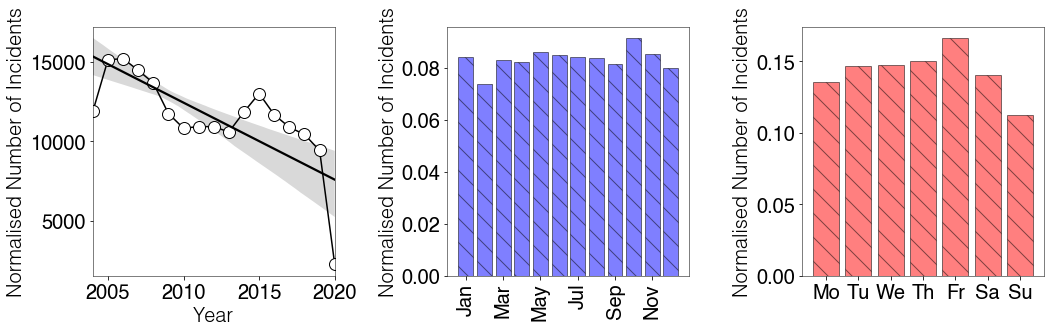

In [1920]:
fig, axs = pl.subplots(1,3,figsize=(15,5))
axs = axs.ravel()

axs[0].plot(np.unique(collisions['year']), collisions['year'].value_counts().sort_index(), marker = markers[0],mfc=mfc,c=c,ms = ms)
sb.regplot(x = np.unique(collisions['year']), y = collisions['year'].value_counts() ,data = collisions,color='k',scatter=False,ax=axs[0])
axs[0].set_xlabel('Year')

axs[1].bar(np.arange(12),collisions['month'].value_counts(normalize = True).sort_index(),edgecolor = c, fc='b',alpha = 0.5,hatch='\\')
axs[1].set_xticks(np.arange(0,12,2));
axs[1].set_xticklabels(['Jan','Mar','May','Jul','Sep','Nov'], rotation =90);
axs[0].set_ylabel('Normalised Number of incidents')

axs[2].bar(np.arange(7),collisions['dayofweek'].value_counts(normalize = True).sort_index(),edgecolor = c, fc='r',alpha=0.5,hatch='\\')
axs[2].set_xticks(np.arange(7))
axs[2].set_xticklabels(['Mo','Tu','We','Th','Fr','Sa','Su']);

for i in range(3):axs[i].set_ylabel('Normalised Number of Incidents')
hide_toggle()

Therefore, we chose the location as our discrimination parameter. Using data for the different <a href='https://github.com/seattleio/seattle-boundaries-data'> Seattle neighbourhoods</a>, and the coordinates provided by the SDP, an interactive map is produced below. The different neighborhoods are coloured according the local number of incidents. Nothe that clicking on the black dots opens a plot showing the accident rate per neighbourhood. Among the neighbourhoods with the highest historic rate we find First Hill and Central Business District. To study regions with high rate, we only select neighbourhoods with **4,000** collisions or more.

In [1916]:
with open('neighborhoods.geojson','r') as file:
    seattle_neighs = json.load(file)

def get_plot(data,name):
    colors = 'Paired'
    points = {
        'year' : data[:,0].tolist(),
        'Number of Collisions' : data[:,1].tolist(),
        }
    bar = vincent.Bar(points,iter_idx='year',
                     width = 500,
                     height = 175,)
    bar.colors(brew=colors)
    bar.legend(title=name)
    bar.axis_titles(x='Year', y='') 
    return json.loads(bar.to_json())

def collisions_per_nhood(data,geodata):
    centres = []
    neighs = {}
    cnt = 0
    for i,neigh in enumerate(geodata['features']):
        if neigh['properties']['city'] != 'Seattle':
            pass
        else:
            coords =  np.vstack(neigh['geometry']['coordinates'][0])
            centre = np.array([np.mean(coords[:,0]),np.mean(coords[:,1])])
            neighs[cnt] = [neigh['properties']['name'],centre]
            centres.append(centre)
            cnt += 1

    centres = np.vstack(centres)

    nhoods, this_year,ikey = [],[],[]
    for x,y,year,ik in zip(data['X'],data['Y'],data['year'],data['INCKEY']):
        this_point = np.array([x,y]).reshape(1,2)
        dists = cdist(centres,this_point)
        closest = dists.argmin()
        nhoods.append(neighs[closest][0])
        this_year.append(year)
        ikey.append(ik)
        
    coll_nhoods = pd.Series(nhoods,this_year).to_frame()
    coll_nhoods.reset_index(inplace=True)
    coll_nhoods.rename(columns = {'index':'year',0:'NHOOD'}, inplace = True)
    coll_nhoods['INCKEY'] = ikey
    
    n_coll_nhoods=coll_nhoods['NHOOD'].value_counts().to_frame()
    n_coll_nhoods.reset_index(inplace = True)
    n_coll_nhoods.rename(columns = {'index':'NHOOD','NHOOD':'NUMBER'},inplace = True)
    
    neighborhoods = {}
    for j in neighs:
        neighborhoods.setdefault(neighs[j][0],{})
        neighborhoods[neighs[j][0]].setdefault('centre',[])
        neighborhoods[neighs[j][0]].setdefault('data',[])
        neighborhoods[neighs[j][0]].setdefault('ikeys',[])

    nhood_year = coll_nhoods.groupby(['NHOOD'])['year'].value_counts()
    for k,n in enumerate(nhood_year.index):
        neighborhoods[n[0]]['data'].append([n[1],nhood_year.iat[k]])
        
    keys = coll_nhoods.groupby(['NHOOD'])['INCKEY'].value_counts()
    for l,n_ in enumerate(keys.index):
        neighborhoods[n_[0]]['ikeys'].append(n_[1])
        
    for key in neighs:
        this_neigh = neighs[key][0]
        for this_neigh_ in neighborhoods:
            if this_neigh == this_neigh_:
                neighborhoods[this_neigh_]['centre'].append(neighs[key][1])
    
    return n_coll_nhoods,centres,neighborhoods


def get_map(data,neighs,geodata,map_name,markers=True):
    seattle_map = folium.Map(location = [collisions['Y'].mean(), collisions['X'].mean()],
                         tiles='cartodbpositron',
                         zoom_start=11)
    folium.Choropleth(
        geo_data=geodata,
        name='Collisions',
        data=data,
        columns=['NHOOD', 'NUMBER'],
        key_on='properties.name',
        bins = 8,
        fill_color='Paired',
        fill_opacity=1.,
        line_opacity=0.35,
        nan_fill_opacity = 0.0,
        legend_name = 'Number of Collisions',
    ).add_to(seattle_map)
    
    if markers:
        for i,this in enumerate(nhoods):
            plot_data = np.vstack(nhoods[this]['data'])
            folium.Circle(
                location=np.roll(nhoods[this]['centre'][0],1,axis=0).tolist(),
                tooltip = this,
                popup = folium.Popup(max_width=650).add_child(folium.Vega(
                                                                        get_plot(plot_data,this), 
                                                                        width=650, 
                                                                        height=225)),
                radius = 30,
                color='Black',
                fill_color = 'Black'
                ).add_to(seattle_map)

    folium.LayerControl('topright',collapsed = True).add_to(seattle_map)

    seattle_map.save('Maps/{}.html'.format(map_name))
    return seattle_map
hide_toggle()

In [1917]:
historic_collisions,centres, nhoods = collisions_per_nhood(collisions,seattle_neighs)
get_map(historic_collisions,nhoods,seattle_neighs,map_name='historic_map',markers=True)

# Data Analysis <a name='analysis'></a>

Having identified the zones with the highest historic rate, we proceed to look at the several conditions that might lead to a collision, such as the **influence of alochol or drugs**. Moreover, we analyse the type of collision and its classification according the **severity code** provided, where ***1*** represents property damage, and ***2*** is an injury. Note that most of the incidents have occured without the influece of recreational substances or alcohol, as shown in the pie chart. We now proceed to analyse the weather, road and light conditions. Note that the counts of these are plotted below on a log scale for clarity. Interestingly, must of the collisions have ocurred in optimal conditions, e.g. **clear weather**, **dry roads**, and during **daylight**. Nonetheless, we consider all the remaining conditions for the prediction models used below. Such models are used to predict the value of both **severity code** and **collision type**. The pie chart below indicates that only ~30% of the collision result in injury. on the other hand, for the type of coliision, the most frequent incidents correspond to parked cars, collisions coming from angles and rear end.

In [1835]:
most = []
for neigh in nhoods:
    most.append([neigh,len(nhoods[neigh]['ikeys'])])

mostKeys = []
thres = 4000.

for neigh in nhoods:
    data = np.vstack(nhoods[neigh]['data'])
    if data[:,1].sum() >= thres:
        mostKeys.append(nhoods[neigh]['ikeys'])

mostKeys = np.hstack(mostKeys)

mostCollisions = [collisions[collisions['INCKEY'] == mk] for mk in mostKeys]
mostCollisions = pd.concat(mostCollisions)
mostCollisions.drop(['INTKEY',
                     'INATTENTIONIND',
                     'OBJECTID',
                     'SPEEDING',
                     'ST_COLDESC',
                     'REPORTNO',
                     'STATUS','INCDATE',
                     'PEDROWNOTGRNT',
                     'COLDETKEY',
                     'SEGLANEKEY',
                     'CROSSWALKKEY',
                     'EXCEPTRSNCODE',
                     'EXCEPTRSNDESC',
                     'SDOT_COLCODE',
                     'SDOTCOLNUM'], axis = 1, inplace = True)
mostCollisions.dropna(axis=0,inplace=True)
hide_toggle()

In [1869]:
mostCollisions['ADDRTYPE'].replace(to_replace=['Block','Intersection'], value=[0,1],inplace=True)
mostCollisions['HITPARKEDCAR'].replace(to_replace=['N','Y'], value=[0,1],inplace=True)
mostCollisions['UNDERINFL'].replace(to_replace=['N','Y','0','1'], value=[0,1,0,1],inplace=True)

params = mostCollisions[['ADDRTYPE','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT','UNDERINFL']]
params = pd.concat([params,pd.get_dummies(mostCollisions['WEATHER']),pd.get_dummies(mostCollisions['ROADCOND']),pd.get_dummies(mostCollisions['WEATHER'])], axis = 1)
params.drop(['Unknown','Other'],axis=1,inplace=True)

hide_toggle()

### Parameters

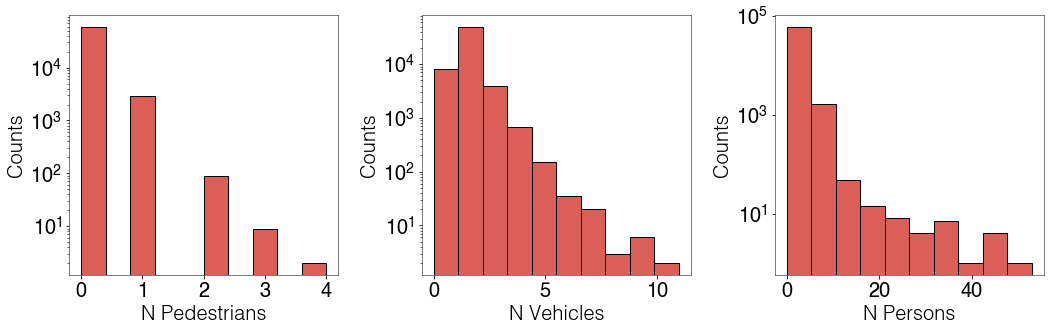

In [1923]:
fig,axs = pl.subplots(1,3,figsize = (15,5))
axs = axs.ravel()
mostCollisions['PEDCOUNT'].hist(ax=axs[0],edgecolor='k')
axs[0].set_xticks(np.arange(5))
axs[0].set_ylabel('Counts')
axs[0].set_xlabel('N Pedestrians')
axs[0].set_yscale('log')
axs[0].grid()

mostCollisions['VEHCOUNT'].hist(ax=axs[1],edgecolor='k')
axs[1].set_ylabel('Counts')
axs[1].set_xlabel('N Vehicles')
axs[1].set_yscale('log')
axs[1].grid()

mostCollisions['PERSONCOUNT'].hist(ax=axs[2],edgecolor='k')
axs[2].set_ylabel('Counts')
axs[2].set_xlabel('N Persons')
axs[2].set_yscale('log')
axs[2].grid()

hide_toggle()

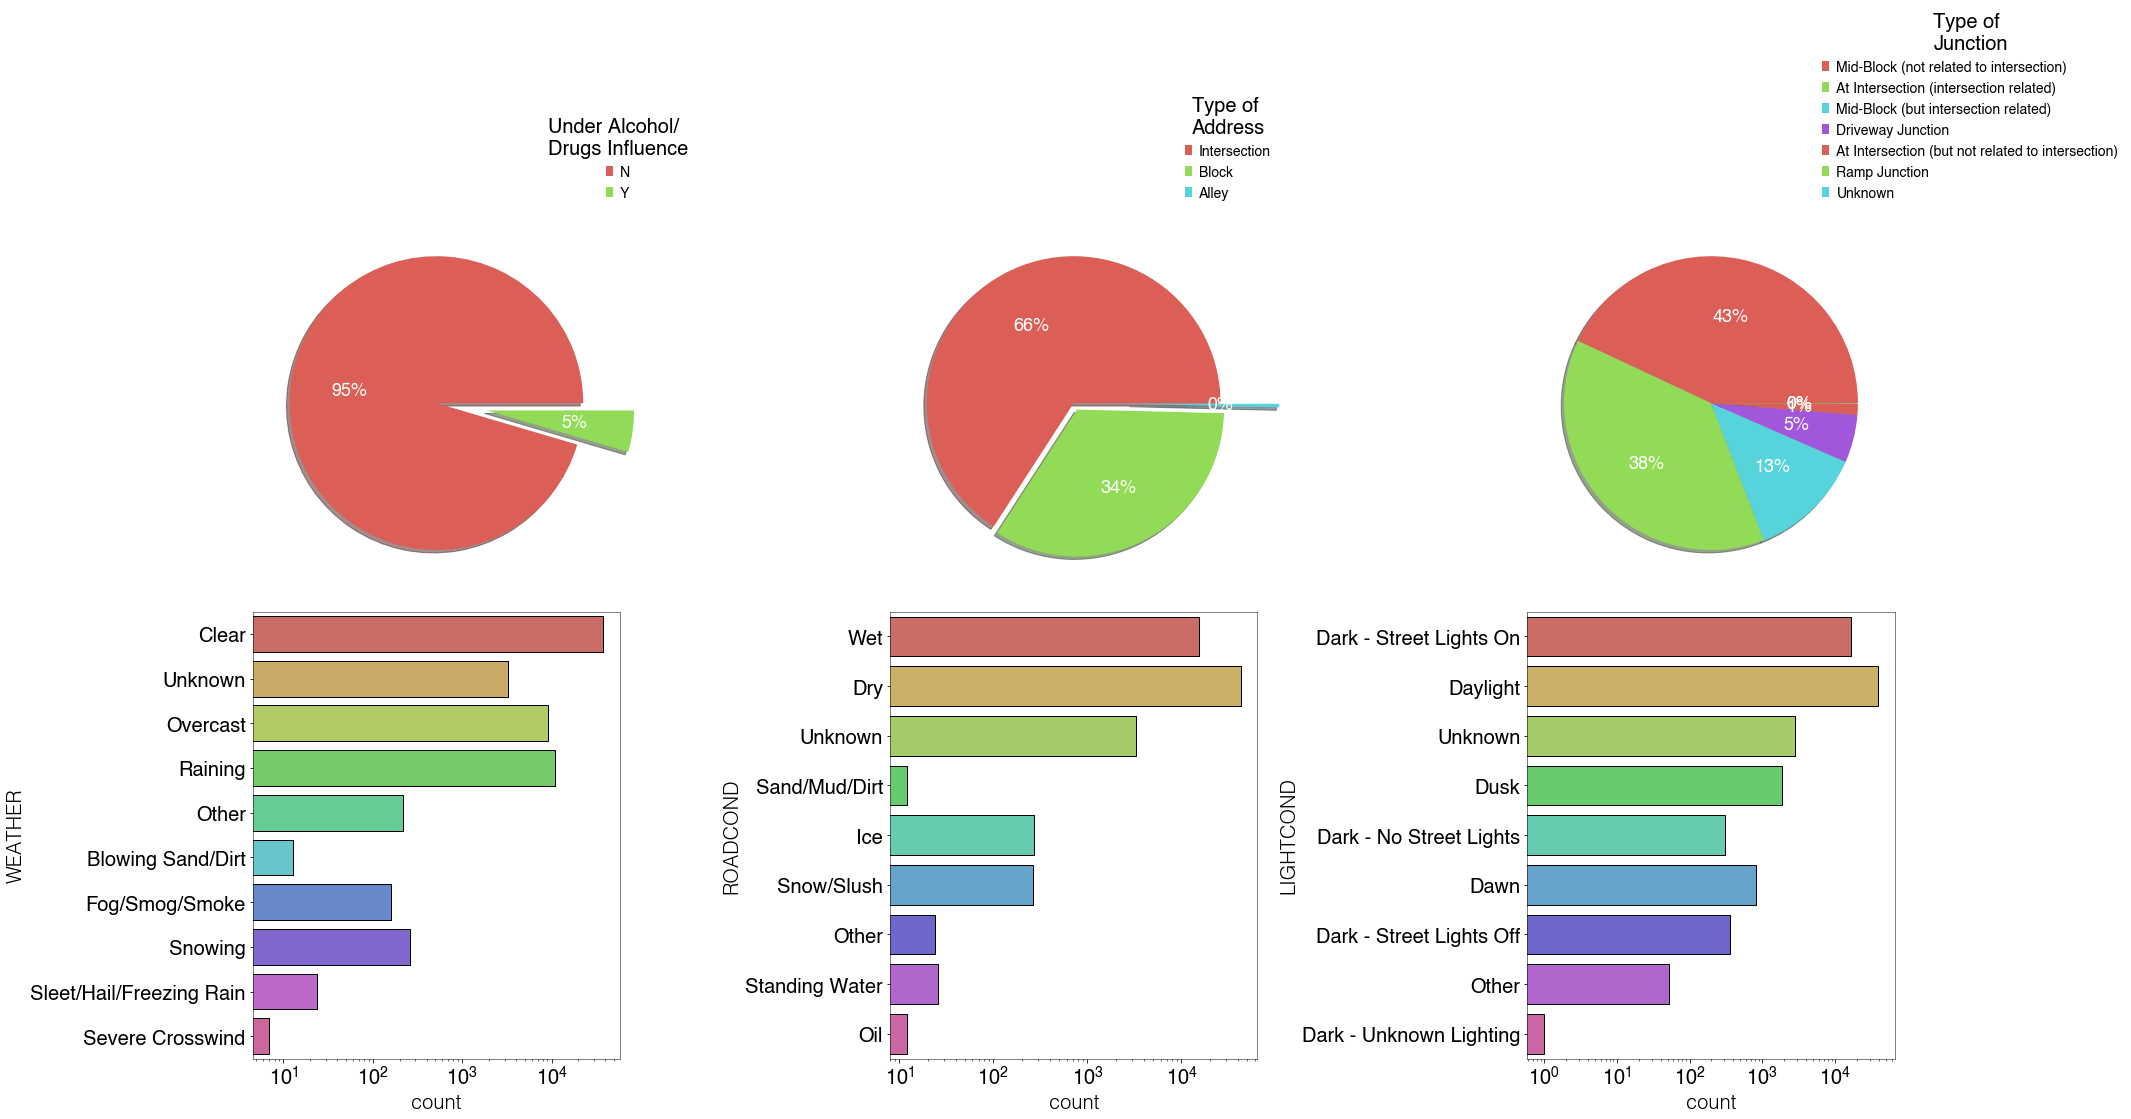

In [1924]:
sb.set_palette(sb.color_palette("hls",4))
fig,axs = pl.subplots(2,3,figsize=(30,16))
axs = axs.ravel()

infl = mostCollisions['UNDERINFL'].to_frame()
infl['UNDERINFL'].replace(to_replace=[0,1], value=['N','Y'],inplace=True)
axs[0].pie(infl['UNDERINFL'].value_counts(), 
           textprops={'color':'white', 'fontsize': 18}, 
           autopct='%1.0f%%',
           explode=[0,0.35],
           shadow = True)
lgd = axs[0].legend(infl['UNDERINFL'].unique(),
                    title='Under Alcohol/\nDrugs Influence',
                    fontsize=14,
                   bbox_to_anchor=(0.75,1))

addr = collisions['ADDRTYPE'].to_frame()
# infl['UNDERINFL'].replace(to_replace=[0,1], value=['N','Y'],inplace=True)
axs[1].pie(addr['ADDRTYPE'].value_counts(), 
           textprops={'color':'white', 'fontsize': 18}, 
           autopct='%1.0f%%',
           explode=[0,0.05,0.4],
           shadow = True)
lgd = axs[1].legend(addr['ADDRTYPE'].unique(),
                    title='Type of\nAddress',
                    fontsize=14,
                   bbox_to_anchor=(0.75,1))

junc  = mostCollisions['JUNCTIONTYPE'].to_frame()
junc['JUNCTIONTYPE'].replace(to_replace=[0,1], value=['N','Y'],inplace=True)
axs[2].pie(junc['JUNCTIONTYPE'].value_counts(), 
           textprops={'color':'white', 'fontsize': 18}, 
           autopct='%1.0f%%',
           shadow = True)
lgd = axs[2].legend(junc['JUNCTIONTYPE'].unique(),
                    title='Type of\nJunction',
                    fontsize=14,
                   bbox_to_anchor=(0.75,1))
            

sb.countplot(y ='WEATHER', palette="hls", data = mostCollisions,ax=axs[3],edgecolor='k') 
axs[3].set_xscale('log')
sb.countplot(y ='ROADCOND', palette="hls", data = mostCollisions,ax=axs[4],edgecolor='k') 
axs[4].set_xscale('log')
sb.countplot(y ='LIGHTCOND', palette="hls", data = mostCollisions,ax=axs[5],edgecolor='k') 
axs[5].set_xscale('log')
fig.tight_layout()


hide_toggle()

### Types of collision

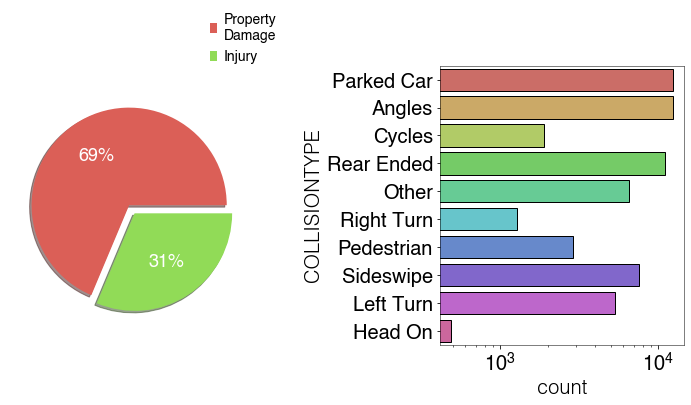

In [1925]:
fig,axs = pl.subplots(1,2,figsize=(10,6))
axs = axs.ravel()

sev = mostCollisions['SEVERITYCODE'].to_frame()
sev['SEVERITYCODE'].replace(to_replace=[1,2], value=['Property\nDamage','Injury'],inplace=True)
axs[0].pie(sev['SEVERITYCODE'].value_counts(), 
           textprops={'color':'white', 'fontsize': 18}, 
           autopct='%1.0f%%',
           explode=[0,0.1],
           shadow = True)
lgd = axs[0].legend(sev['SEVERITYCODE'].unique(),
                    fontsize=14,
                   bbox_to_anchor=(0.75,1))

sb.countplot(y ='COLLISIONTYPE', palette="hls", data = mostCollisions,ax=axs[1],edgecolor='k') 
axs[1].set_xscale('log')
fig.tight_layout()

hide_toggle()

In [1844]:
x = preprocessing.StandardScaler().fit(params).transform(params)

y1 = mostCollisions['SEVERITYCODE'].values
y2 = mostCollisions['COLLISIONTYPE'].values

le1 = preprocessing.LabelEncoder()
y1_ = le1.fit_transform(y1)

le2 = preprocessing.LabelEncoder()
y2_ = le2.fit_transform(y2)

x_train1,x_test1,y_train1,y_test1 = train_test_split(x,y1_,test_size = 0.2,random_state = 3)
x_train2,x_test2,y_train2,y_test2 = train_test_split(x,y2_,test_size = 0.2,random_state = 3)

y_test2_s = pd.Series(y2_).value_counts(normalize = True).sort_index()
y_test1_s = pd.Series(y1_).value_counts(normalize = True).sort_index()

hide_toggle()

In [1843]:
def get_pred_series(pred):
    pred_s = pd.Series(pred)
    return pred_s.value_counts(normalize = True).to_frame().sort_index()

def plot_real_vs_pred(pred1_,pred2_,legend = None):
    fig,axs = pl.subplots(1,2,figsize=(10,6))
    axs = axs.ravel()

    axs[0].bar(pred1_.index,pred1_.values[:,0],fc='b',edgecolor='k',hatch = '\\',zorder= 1,alpha=0.5,label = '{} Prediction'.format(legend))
    axs[0].bar(y_test1_s.index,y_test1_s.values, color = 'r',alpha=0.35,zorder=0, edgecolor = 'k',width = 1.,label = 'Original Data')
    axs[0].set_xticks(np.arange(2));
    axs[0].set_xticklabels(['Property\nDamage','Injury'])
    axs[0].set_ylabel('Normalised Counts')
    axs[0].legend(fontsize = 14)

    axs[1].bar(pred2_.index,pred2_.values[:,0],fc='b',edgecolor='k',hatch = '\\',zorder= -1,alpha=0.5,width = 0.65,label = '{} Prediction'.format(legend))
    axs[1].bar(y_test2_s.index,y_test2_s.values, color = 'r',alpha=0.35,zorder=2, edgecolor = 'k',width = 1.,label = 'Original Data')
    axs[1].set_xticks(np.arange(y_test2_s.values.shape[0]));
    axs[1].set_xticklabels(le2.inverse_transform(y_test2_s.index),rotation=90);
    axs[1].set_ylabel('Normalised Counts');
    
hide_toggle()

# Modeling  <a name ='modeling'></a>

Based on the data provided we select a series of methods to predict the type of collision and the result of the same, classifies either as property damage or injury. The methods selected are:

- <code>kNN</code>: k Nearest Neighbours
- <code>Decision Tree</code>
- <code>SVM</code>: Support Vector Machine
- <code>Logistic Regression</code>

We select a series of paramaters from the original data to train and test the suggested models. First, we filter the data based on the local number of collisions per neighbourhood. We take 4,000 incidents as our threshold. This process is followed by the selection of parameters to be used from the data analysis. We select:

- <code>ADDRTYPE</code>
- <code>PERSONCOUNT</code>
- <code>PEDCOUNT</code>
- <code>PEDCYLCOUNT</code>
- <code>VEHCOUNT</code>
- <code>UNDERINFL</code>
- <code>WEATHER</code>
- <code>ROADCOND</code>
- <code>LIGHTCOND</code>

## K Nearest Neighbor(KNN)

In [1851]:
k = 15
means1,means2 = [], []
for i in range(1,k):
    KNN_model1 = KNeighborsClassifier(n_neighbors=i).fit(x_train1,y_train1)
    KNN_model2 = KNeighborsClassifier(n_neighbors=i).fit(x_train2,y_train2)
    KNN_pred1 = KNN_model.predict(x_test1)
    means1.append(np.mean(KNN_pred1 == y_test1))
    
    KNN_pred2 = KNN_model.predict(x_test2)
    means2.append(np.mean(KNN_pred2 == y_test2))
hide_toggle()

In [1852]:
best_k1 = np.array(means1).argmax()+1
best_k2 = np.array(means1).argmax()+1

KNN_model1 = KNeighborsClassifier(n_neighbors=best_k1).fit(x_train1,y_train1)
KNN_pred1 = KNN_model1.predict(x_test1)

KNN_model2 = KNeighborsClassifier(n_neighbors=best_k2).fit(x_train2,y_train2)
KNN_pred2 = KNN_model2.predict(x_test2)

KNN_proba1 = KNN_model1.predict_proba(x_test1)[::,1]
KNN_proba2 = KNN_model2.predict_proba(x_test2)[::,1]

KNN_acc1 =  metrics.accuracy_score(y_test1,KNN_pred1)
KNN_jaccard_1 = metrics.jaccard_score(y_test1, KNN_pred1)
KNN_f1_1 = metrics.f1_score(y_test1, KNN_pred1, average='weighted')

KNN_acc2 =  metrics.accuracy_score(y_test2,KNN_pred2)
KNN_f1_2 = metrics.f1_score(y_test2, KNN_pred2, average='weighted')

KNN_pred1_ = get_pred_series(KNN_pred1)
KNN_pred2_ = get_pred_series(KNN_pred2)

hide_toggle()

The accuracy is {KKN_acc1}

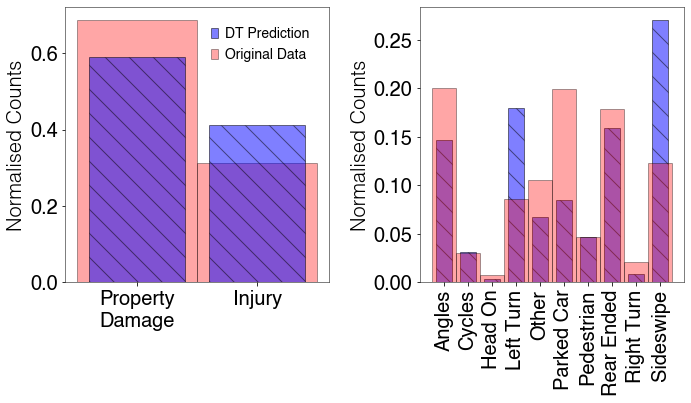

In [1926]:
plot_real_vs_pred(KNN_pred1_,KNN_pred2_,'DT')

## Decision Tree

In [1853]:
DT_model1 = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
DT_model2 = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
DT_model1.fit(x_train1,y_train1)
DT_model2.fit(x_train2,y_train2)

DT_pred1 = DT_model1.predict(x_test1)
DT_pred2 = DT_model2.predict(x_test2)

DT_proba1 = DT_model1.predict_proba(x_test1)
DT_proba2 = DT_model2.predict_proba(x_test2)

DT_pred1_ = get_pred_series(DT_pred1)
DT_pred2_ = get_pred_series(DT_pred2)

DT_acc1 =  metrics.accuracy_score(y_test1,DT_pred1)
DT_jaccard_1 = metrics.jaccard_score(y_test1, DT_pred1)
DT_f1_1 = metrics.f1_score(y_test1, DT_pred1, average='weighted')

DT_acc2 =  metrics.accuracy_score(y_test2,DT_pred2)
DT_f1_2 = metrics.f1_score(y_test2, DT_pred2, average='weighted')

hide_toggle()

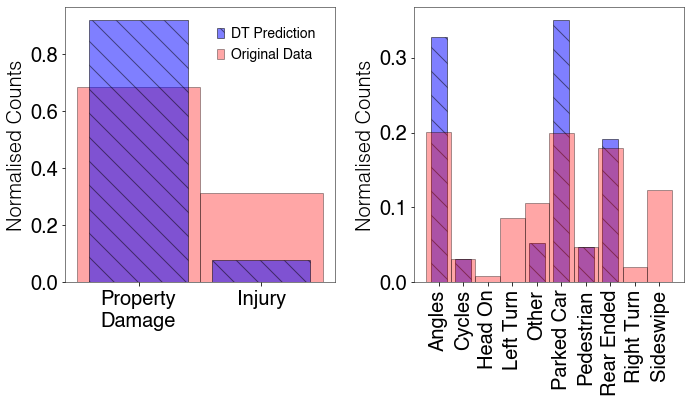

In [1927]:
plot_real_vs_pred(DT_pred1_,DT_pred2_,'DT')

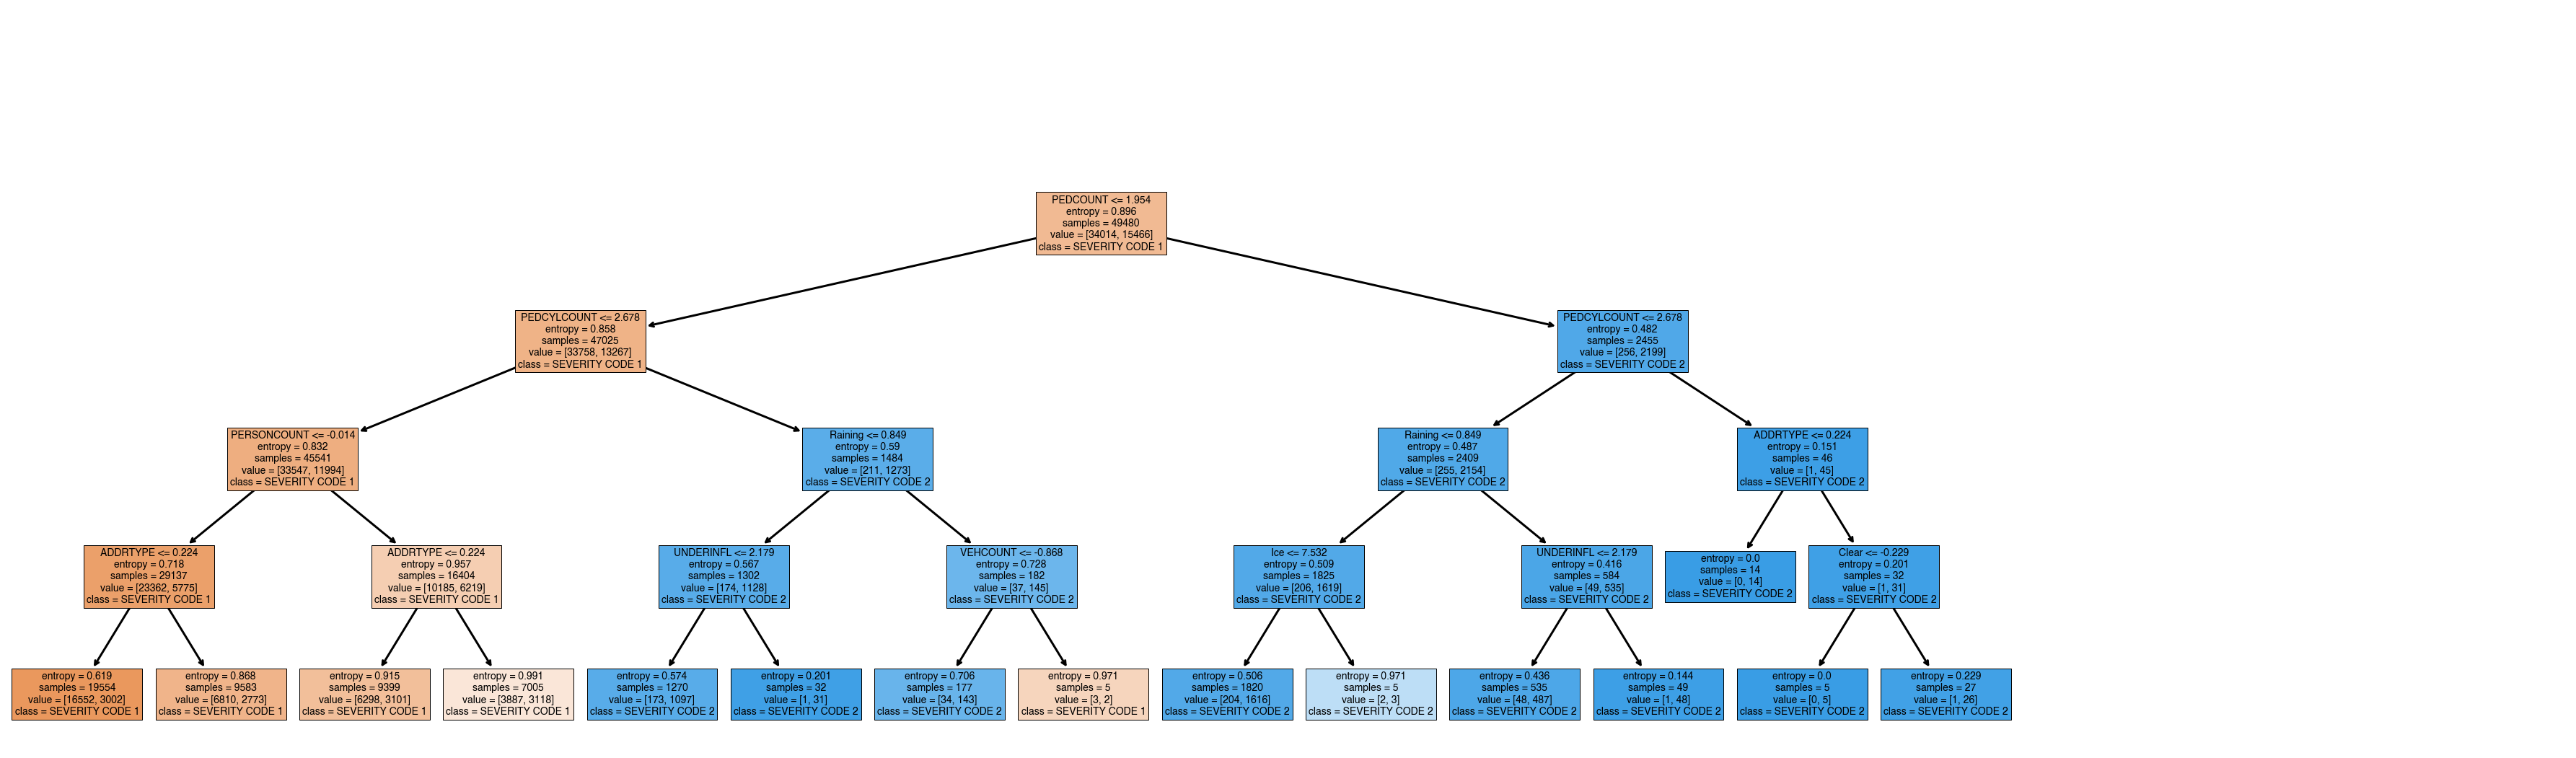

In [1928]:
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (50,15))

tree_ = tree.plot_tree(DT_model1,
               feature_names = list(params.columns),
               class_names = ['SEVERITY CODE 1','SEVERITY CODE 2'],
               fontsize = 14,
               filled = True);

for t in tree_:
    arrow = t.arrow_patch
    if arrow != None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)

hide_toggle()

## Support Vector Machine

In [1856]:
SVM_model1 = svm.SVC(probability = True)
SVM_model2 = svm.SVC()
SVM_model1.fit(x_train1, y_train1) 
SVM_model2.fit(x_train2, y_train2)

SVM_pred1 = SVM_model1.predict(x_test1)
SVM_pred2 = SVM_model2.predict(x_test2)

SVM_pred1_ = get_pred_series(SVM_pred1)
SVM_pred2_ = get_pred_series(SVM_pred2)

SVM_acc1 =  metrics.accuracy_score(y_test1,SVM_pred1)
SVM_jaccard_1 = metrics.jaccard_score(y_test1, SVM_pred1)
SVM_f1_1 = metrics.f1_score(y_test1, SVM_pred1, average='weighted')

SVM_acc2 =  metrics.accuracy_score(y_test2,SVM_pred2)
SVM_f1_2 = metrics.f1_score(y_test2, SVM_pred2, average='weighted')

hide_toggle()

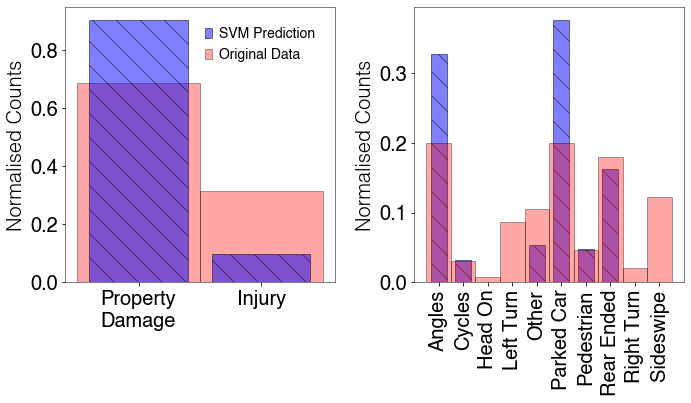

In [1929]:
plot_real_vs_pred(SVM_pred1_,SVM_pred2_,'SVM')

## Logistic Regression

In [1912]:
LR_model1 = LogisticRegression(C=0.01).fit(x_train1,y_train1)
LR_model2 = LogisticRegression(C=0.01).fit(x_train2,y_train2)

LR_pred1 = LR_model1.predict(x_test1)
LR_pred2 = LR_model2.predict(x_test2)

LR_acc1 =  metrics.accuracy_score(y_test1,LR_pred1)
LR_jaccard_1 = metrics.jaccard_score(y_test1, LR_pred1)
LR_f1_1 = metrics.f1_score(y_test1, LR_pred1, average='weighted')

LR_acc2 =  metrics.accuracy_score(y_test2,LR_pred2)
LR_f1_2 = metrics.f1_score(y_test2, LR_pred2, average='weighted')

LR_pred1_ = get_pred_series(LR_pred1)
LR_pred2_ = get_pred_series(LR_pred2)

hide_toggle()

/Users/Abraham/.pyenv/versions/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


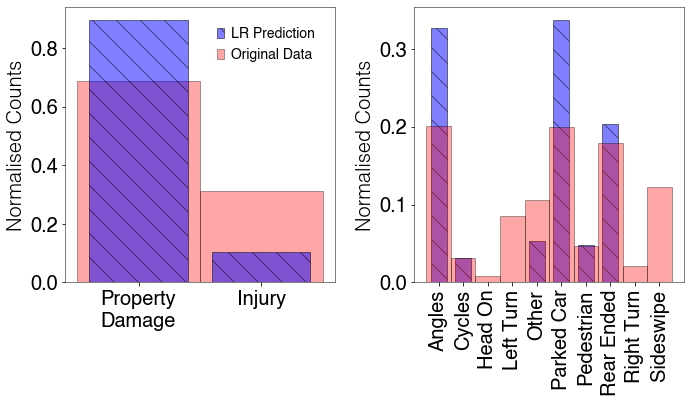

In [1930]:
plot_real_vs_pred(LR_pred1_,LR_pred2_,'LR')

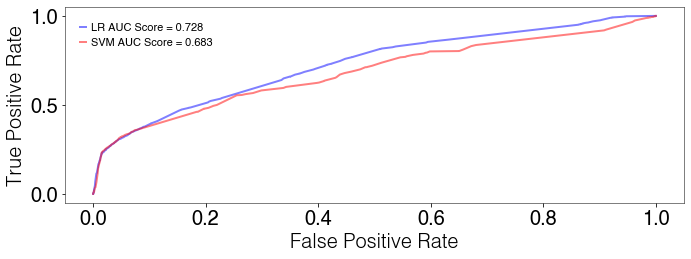

In [1931]:
# LR_proba1 = LR_model1.predict_proba(x_test1)
# LR_fp, LR_tpr, _ = metrics.roc_curve(y_test1, LR_proba1[:,1])
# LR_auc = metrics.roc_auc_score(y_test1,  LR_proba1[:,1])

# SVM_proba1 = SVM_model1.predict_proba(x_test1)
# SVM_fp, SVM_tpr, _ = metrics.roc_curve(y_test1, SVM_proba1[:,1])
# SVM_auc = metrics.roc_auc_score(y_test1,  SVM_proba1[:,1])

fig,axs = pl.subplots(1,1,figsize=(10,4))
axs.plot(LR_fp,LR_tpr,lw=2,c='b',alpha=0.5,label = 'LR AUC Score = {:0.3f}'.format(LR_auc))
axs.plot(SVM_fp,SVM_tpr,lw=2,c='r',alpha = 0.5,label = 'SVM AUC Score = {:0.3f}'.format(SVM_auc))
axs.legend()
axs.set_xlabel('False Positive Rate');
axs.set_ylabel('True Positive Rate');
hide_toggle()

## Model Evaluation <a name ='evaluation'></a>

In [1861]:
methods = ['Decision Tree', 'K Nearest Neighs', 'SVM','Logistic Regression']
acc_all_1 = [DT_acc1, KNN_acc1, SVM_acc1,LR_acc1]
jaccard_all_1 = [DT_jaccard_1, KNN_jaccard_1, SVM_jaccard_1,LR_jaccard_1]
f1_all_1 = [DT_f1_1,KNN_f1_1,SVM_f1_1,LR_f1_1]

md = {'Method':methods, 'Accuracy':acc_all_1, 'Jaccard':jaccard_all_1, 'F1-Score': f1_all_1}

evaluation = pd.DataFrame(md)
evaluation.set_index('Method', inplace=True)
hide_toggle()

In [1862]:
evaluation

Accuracy   Jaccard  F1-Score
Method                                           
Decision Tree        0.745130  0.217424  0.687966
K Nearest Neighs     0.614744  0.307569  0.625487
SVM                  0.748767  0.244898  0.699792
Logistic Regression  0.747797  0.250540  0.701211

In [1863]:
acc_all_2 = [DT_acc2, KNN_acc2, SVM_acc2,LR_acc2]
f1_all_2 = [DT_f1_2,KNN_f1_2,SVM_f1_2,LR_f1_2]

md = {'Method':methods, 'Accuracy':acc_all_2, 'F1-Score': f1_all_2}

evaluation2 = pd.DataFrame(md)
evaluation2.set_index('Method', inplace=True)
hide_toggle()

In [1864]:
evaluation2

Accuracy  F1-Score
Method                                 
Decision Tree        0.534233  0.465348
K Nearest Neighs     0.382831  0.398345
SVM                  0.524937  0.455648
Logistic Regression  0.537143  0.467892